In [1]:
from qutip import *
from qutip.operators import *
import matplotlib.pyplot as plt
import numpy as np 
%matplotlib inline
from cython import *
from sympy import lambdify

# Parameters

In [12]:
N = [5,5]
Ec = [1,1]
Ej = [10,10]
Eu = 0.1
gamma_m = 0
#needed_Ej =0
#evecs = []

In [13]:
tlist_t = 1000
timesteps = 300
tlist = np.linspace(0,tlist_t,timesteps)

# Pulse

In [20]:

a = 100
b = 900
st = 2

time_coeff = "(1-nEj/Ej*0.5*(tanh((t-a)/st) - tanh((t-b)/st)))"
args = {'nEj':needed_Ej, 'a':a, 'b':b,'st':st, 'Ej':Ej[0]}



/usr/lib/python3/dist-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


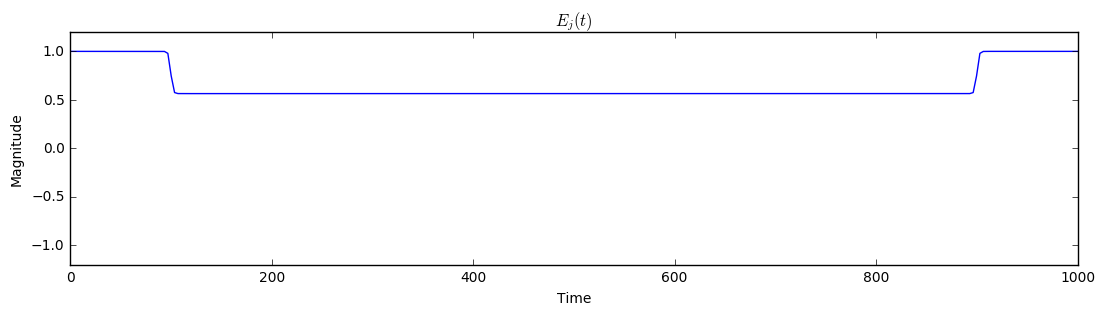

In [21]:
time_c_func = lambdify({'a','b','t','st','nEj','Ej'},time_coeff,'numpy')
fig, ax = plt.subplots(1,1, figsize=(13,3))
ax.set_title('$E_j(t)$');
ax.plot(tlist, time_c_func(a=a,b=b,st=st,nEj=needed_Ej,Ej=Ej[0],t=tlist))
ax.set_ylim(-1.2,1.2)
ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('Magnitude');

# Operators

In [16]:
def n(N_states):
    return num(2*N_states+1, offset = -N_states)

def I(N_states):
    return identity(2*N_states+1)

def Hc(N_states = N[0], Ec = Ec[0], n_g = 0):
    return 4*Ec*(n(N_states)-n_g)**2

def Hj(N_states = N[0], Ej = Ej[0]):
    return -0.5*Ej*Qobj(np.diag(np.ones(2*N_states), -1)+np.diag(np.ones(2*N_states), 1))

def Hq(N_states = N[0], Ej = Ej[0], Ec = Ec[0]):
    return Hc(N_states,Ec) + Hj(N_states,Ej)

def c(N_states=N,evecs=evecs, Ej = Ej, Ec = Ec):
    return sum([n(N).matrix_element(evecs[j], evecs[j+1])/n(N).matrix_element(evecs[0], evecs[1])\
                    * evecs[j]*evecs[j+1].dag() for j in range(0, len(evecs)-1)])

def collapse_list(N_states = N,gamma_m = gamma_m):
    collapse_list = []
    if(gamma_m > 0):
        collapse_list.append(np.sqrt(gamma_m) * c())
    return collapse_list

def S_basis(evecs):
    S = [[el[0] for el in evec.data.toarray()] for evec in evecs ]
    return Qobj(S)
def convert_2toN(A2d,evecs):
    B2d = A2d.data.toarray()
    A = np.zeros(shape=(len(evecs),len(evecs)),dtype=np.complex128)
    A[0][0] = B2d[0][0]
    A[0][1] = B2d[0][1]
    A[1][0] = B2d[1][0]
    A[1][1] = B2d[1][1]
    Aq = Qobj(A)
    return Aq.transform(evecs,True)

def Hq_evecs(N_states = N[0], Ej = Ej[0], Ec = Ec[0]):
        return Hq(N_states,Ej,Ec).eigenstates()[1]
def Hq_evals(N_states = N[0], Ej = Ej[0], Ec = Ec[0]):
        return Hq(N_states,Ej,Ec).eigenstates()[0]


In [29]:
evecs = Hq_evecs()
evals = Hq_evals()
psi0 = evecs[0]
print((evals[1]-evals[0]))
print((evals[2]-evals[1]))

w10 = evals[1] - evals[0]
w12 = evals[2] - evals[1]

args['w'] = w10

7.89950647423
5.3496493099


In [18]:
Ej_space = np.linspace(4.358,4.362, 100)

difs = []
for Ej_id, E_j in enumerate(Ej_space):
    evals, evecs = Hq(N[0],E_j,Ec[0]).eigenstates()
    difs.append(abs(evals[1] - evals[0] - w12))
m = min(difs)
needed_Ej = 0
for d_id, d in enumerate(difs):
    if d == m:
        needed_Ej = (Ej_space[d_id])
print(needed_Ej)        
evals, evecs = Hq(N[0], needed_Ej, Ec[0]).eigenstates()
print(evals[1] - evals[0])
print(evals[2] - evals[1])

4.35941414141
5.34965754073
1.71880385819


# Operators in tensor basis

In [22]:
def T(oper, qubit, N = N):
    if qubit == 1:
        return tensor(oper, I(N[1]))
    else:
        return tensor(I(N[0]), oper)
def THc(qubit, N = N, Ec = Ec, n_g = 0):
    return T(Hc(N[qubit-1],Ec[qubit-1]),qubit,N)    
def THj(qubit, N = N, Ej = Ej, n_g = 0):
    return T(Hj(N[qubit-1],Ej[qubit-1]),qubit,N) 

def THq(qubit, N = N, Ej = Ej, Ec = Ec):
    return THc(qubit) + THj(qubit)
    
def THqq(N = N, Ej = Ej, Ec = Ec):
    return THq(1) + THq(2)

def THic(N = N, Eu = Eu):
    return Eu * tensor(n(N[0]),n(N[1]))

def T2N(oper, qubit, N = N):
    return T(convert_2toN(oper,Hq(N[qubit-1]).eigenstates()[1]),qubit,N)

def TSx(qubit, N = N):
    return T2N(sigmax(),qubit, N)

def TSy(qubit, N = N):
    return T2N(sigmay(),qubit, N)

def TSz(qubit, N = N):
    return T2N(sigmaz(),qubit, N)

def TSp(qubit, N = N):
    return T2N(sigmap(),qubit, N)

def TSm(qubit, N = N):
    return T2N(sigmam(),qubit, N)

In [23]:
def THq_int(N = N, Ej = Ej, Ec = Ec, Eu = Eu):
    return THqq(N,Ej,Ec) + THic(N,Eu)
print(Eu)
print(time_coeff)
print(args)
def THq_t(time_coeff = time_coeff, N = N, Ej = Ej, Ec = Ec, Eu = Eu):
    print(Eu)
    return [THic(N,Eu) + THc(1) + THc(2) + THj(2), [THj(1) , time_coeff]] 


0.1
(1-nEj/Ej*0.5*(tanh((t-a)/st) - tanh((t-b)/st)))
{'b': 900, 'Ej': 10, 'st': 2, 'nEj': 4.359414141414141, 'a': 100}


# Visualisation

In [24]:
def visualize_output(output):
    fig, axes = plt.subplots(3,1, figsize=(13,15), sharex=True)
    axes[0].set_title('f = %.3f, $t_{gate}$ = %.0f, $\phi$ = %f'%(f,t_gate1,phase1));
    labels = ['0t','1t','2t']
    labels = ['$\sigma_x$','$\sigma_y$','$\sigma_z$']
    for idx, ax in enumerate(axes):
        ax.plot(tlist, output.expect[idx], label=labels[idx] + " state")
        #ax.plot(tlist, oldoutput.expect[1+idx], label="Transmon %i state"%idx)
        #ax.plot(tlist, 0.2+ 0.1*time_c_func(a=a,b=b,st=st,t=tlist,w=Eq,phase1=phase1,phase2=phase2,a2=a2,b2=b2),label="pulse (not exact)")
        ax.set_ylim(-1.5,1.1)
        ax.legend(bbox_to_anchor = [0,0],loc = "lower left")
        ax.set_xlabel('Time')
    axes[0].set_ylabel('Occupation probability')

In [25]:
def Tvis_out(output):
    fig, axes2d = plt.subplots(3,2, figsize=(13,15), sharex=True)
    #axes[0].set_title('f = %.3f, $t_{gate}$ = %.0f, $\phi$ = %f'%(f,t_gate1,phase1));
    labels = ['$\sigma_x(%d)$','$\sigma_y(%d)$','$\sigma_z(%d)$']
    for idx, axes in enumerate(axes2d):
        for idy, ax in enumerate(axes):
            print("%d %d"%(idx,idy))
            ax.plot(tlist, output.expect[idy*3 + idx], label=labels[idx]%(idy) + " state")
            #ax.plot(tlist, oldoutput.expect[1+idx], label="Transmon %i state"%idx)
            #ax.plot(tlist, 0.2+ 0.1*time_c_func(a=a,b=b,st=st,t=tlist,w=Eq,phase1=phase1,phase2=phase2,a2=a2,b2=b2),label="pulse (not exact)")
            ax.set_ylim(-1.5,1.1)
            ax.legend(bbox_to_anchor = [0,0],loc = "lower left")
            ax.set_xlabel('Time')
    #axes[0].set_ylabel('Occupation probability')

# Dynamics 

In [39]:
expected = [TSx(1),TSy(1),TSz(1),TSx(2),TSy(2),TSz(2)]
ev1 = Hq_evecs(N[0])
ev2 = Hq_evecs(N[1])
#psi1 = (ev1[0]+ev1[1]) / (2**0.5)
#psi2 = (ev2[0]+ev2[1]) / (2**0.5)

psi1 = ev1[0]
#psi2 = ev2[0]

#psi1 = ev1[1]
psi2 = ev2[1]

Tpsi0 = tensor(psi1,psi2)
args['nEj'] = 0
def solve(expected_ops = expected, with_progress_bar = True):
    if with_progress_bar:
        return mesolve(THq_t(), Tpsi0, tlist, collapse_list(), expected_ops, args = args,options= Options(nsteps=10000), progress_bar=True)
    else:
        return mesolve(THq_t(), Tpsi0, tlist, collapse_list(), expected_ops, args = args,options= Options(nsteps=10000))

0.1
{'Ej': 10, 'w': 7.8995064742269481, 'nEj': 4.359414141414141, 'b': 900, 'st': 2, 'a': 100}
0.1
10.0%. Run time:   3.20s. Est. time left: 00:00:00:28
20.0%. Run time:   6.42s. Est. time left: 00:00:00:25
30.0%. Run time:   9.68s. Est. time left: 00:00:00:22
40.0%. Run time:  12.99s. Est. time left: 00:00:00:19
50.0%. Run time:  16.29s. Est. time left: 00:00:00:16
60.0%. Run time:  19.51s. Est. time left: 00:00:00:13
70.0%. Run time:  22.76s. Est. time left: 00:00:00:09
80.0%. Run time:  26.01s. Est. time left: 00:00:00:06
90.0%. Run time:  29.25s. Est. time left: 00:00:00:03
Total run time:  32.46s
0 0
0 1
1 0
1 1
2 0
2 1


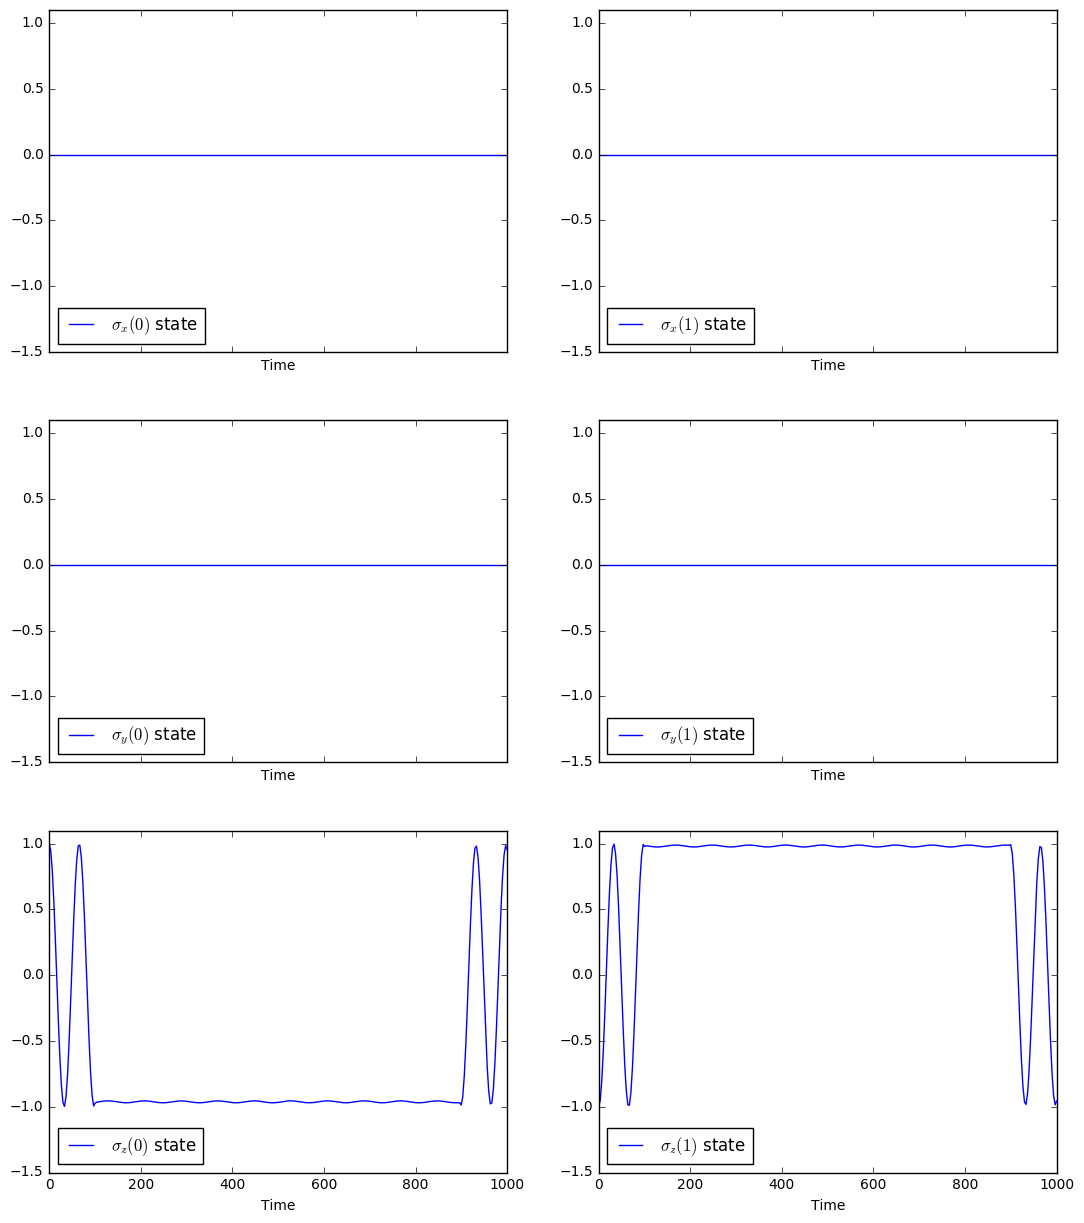

In [41]:
print(Eu)
args['nEj'] = needed_Ej
print(args)
expected = [TSx(1),TSy(1),TSz(1),TSx(2),TSy(2),TSz(2)]
#args['nEj'] = needed_Ej
Tvis_out(solve(expected))

In [30]:
output = solve([])
output2 = output
output2.expect = [[],[],[],[],[],[]]
for time_step, state in enumerate(output.states):
    time = tlist_t / timesteps * time_step
    U = (-convert_2toN(sigmaz(), Hq_evecs())*1j*args['w']/2 * time).expm()
    for qubit in [1,2]:
        TU = T(U,qubit)
        output2.expect[(qubit-1)*3+ 0].append(expect(TU.dag()*TSx(qubit)*TU, state))
        output2.expect[(qubit-1)*3+ 1].append(expect(TU.dag()*TSy(qubit)*TU, state))
        output2.expect[(qubit-1)*3+ 2].append(expect(TU.dag()*TSz(qubit)*TU, state))

0.1
10.0%. Run time:   3.31s. Est. time left: 00:00:00:29
20.0%. Run time:   6.84s. Est. time left: 00:00:00:27
30.0%. Run time:  10.17s. Est. time left: 00:00:00:23
40.0%. Run time:  13.49s. Est. time left: 00:00:00:20
50.0%. Run time:  17.04s. Est. time left: 00:00:00:17
60.0%. Run time:  20.52s. Est. time left: 00:00:00:13
70.0%. Run time:  23.91s. Est. time left: 00:00:00:10
80.0%. Run time:  27.31s. Est. time left: 00:00:00:06
90.0%. Run time:  30.73s. Est. time left: 00:00:00:03
Total run time:  33.98s


0 0
0 1
1 0
1 1
2 0
2 1


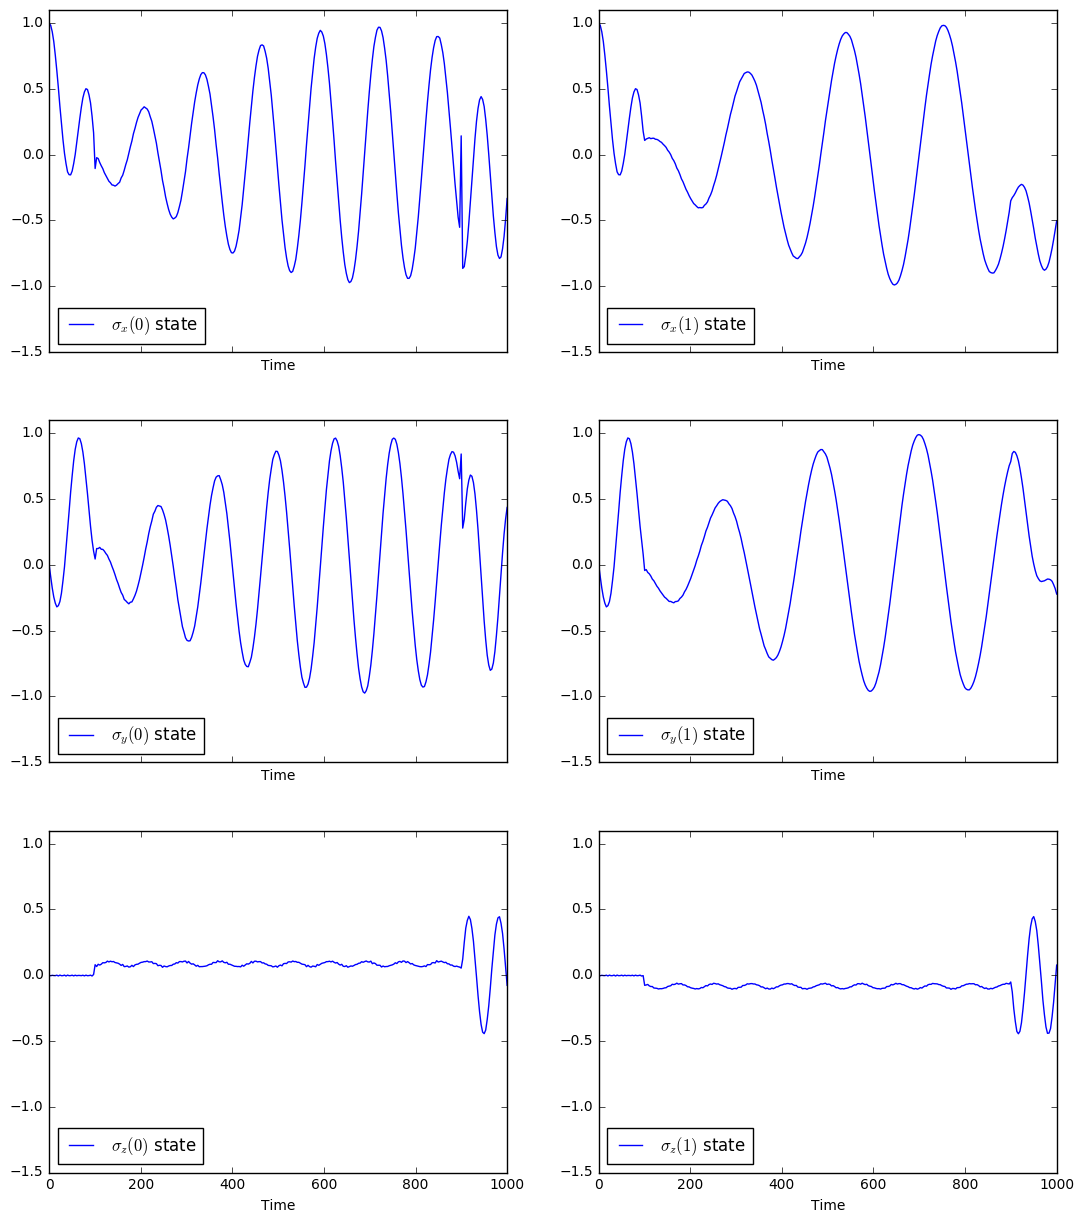

In [31]:
Tvis_out(output2)